In [1]:
# Imports
import numpy as np
import pandas as pd
import itertools as it
import scipy
import scipy.spatial
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def RMSE(y_test, predictions):
    """Compute the root mean squared error

    Parameters
    ----------
    y_test : {array-like}, shape = [n_samples]
        actual values
        
    predictions : {array-like}, shape = [n_samples]
        predicted values
        
    Returns
    ----------
    rmse : float
        the root mean squared error
    """  
    rmse = (np.sqrt(((y_test - predictions)**2).mean()))
    return rmse

In [3]:
class rbf(object):
    """Radial Basis Function (RBF/Gaussian Kernel)
    
    Parameters
    ----------        
    param_b : {Integer, Float}
        rbf parameter, controls kernel width
    
    param_a : {Integer, Float}
        rbf alpha parameter
    """
    def __init__(self, param_b, param_a = 1):
        self.param_b = param_b
        self.param_a = param_a

    def compute(self, pointa, pointb):
        norm = scipy.spatial.distance.cdist(pointa, pointb, 'euclidean')
        return self.param_a * np.exp((-1/self.param_b)*np.square(norm))

In [4]:
class GaussianProcess(object):
    """Gaussian Process Model for Regression
    
    Parameters
    ----------        
    x_train : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y_train : array-like, shape = [n_samples]
        Training targets
    
    kernel : callable
        kernel to be used
        
    sigma : float
        Amplitude to control scaling
    """

    def __init__(self, x_train, y_train, kernel, sigma = .1):
        self.X = x_train
        self.y = y_train
        self.sigma = sigma
        self.kernel = kernel
        self.kernal_covariance = self.kernel.compute(self.X, self.X)
        self.results = {}

    def updateSigma(self, sigma):
        """Update sigma value.
        We do this to re train the model without having to keep re-compute the covariance matrix

        Parameters
        ----------      
        sigma : float
            Amplitude to control scaling
        """
        self.sigma = sigma

    def predict_single(self, new_point):
        """Compute the predicted mean and variance to be used to learn the overall distribution

        Parameters
        ----------      
        new_point : array-like, shape = [1, n_features]
            Single data point
            
        Returns
        ----------      
        Tuple : [Float, Float]
            Mean and Variance
        """
        new_point = np.asmatrix(new_point)
        new_point_kernel = np.array(self.kernel.compute(new_point, self.X).T)
        noise_kernel = self.sigma*np.eye(self.kernal_covariance.shape[0]) + self.kernal_covariance
        kernel_mult = np.dot(np.linalg.inv(noise_kernel), new_point_kernel)
        
        mean = np.ravel(np.dot(kernel_mult.T, self.y))
        variance = np.ravel(self.sigma + self.kernel.compute(new_point, new_point) - np.dot(kernel_mult.T, new_point_kernel))
        
        return [mean, variance]
    
    def trackResults(self, predictions):
        """Track the mean and variance for each sigma

        Parameters
        ----------      
        predictions : List[(Mean, Variance)]
            List of mean and variance for ever 
            
        Returns
        ----------      
        Tuple : [Float, Float]
            Mean and Variance
        """
        means = np.array([x[0] for x in predictions])
        variances = np.array([x[1] for x in predictions])
        self.results[self.sigma] = [means, variances]
    
    def predict(self, x_test):
        """Learn the gaussian approximation of the test set

        Parameters
        ----------      
        test_set : {array-like, sparse matrix},
        shape = [n_samples, n_features]
            Test set
        """
        predictions = [self.predict_single(x_test.loc[i]) for i in range(len(x_test))] 
        self.trackResults(predictions)

In [5]:
# Read in the data
x_train = pd.read_csv('data/X_train.csv', header = None)
y_train = pd.read_csv('data/y_train.csv', header = None)
x_test= pd.read_csv('data/X_test.csv', header = None)
y_test = pd.read_csv('data/y_test.csv', header = None)


In [6]:
# Hyper parameters to try
bs = [x for x in range(5, 16, 2)]
sigmas = [float(x)/10 for x in range(1, 11)]

In [7]:
# Grid search the hyper parameters and compute the error for each using mean as the prediction
error = {}
for b in bs:
    gp = GaussianProcess(x_train, y_train, rbf(b))
    for sigma in sigmas:
        gp.updateSigma(sigma)
        gp.predict(x_test)
        if b in error:
            error[b].append(float(RMSE(y_test, gp.results[sigma][0])))
        else:
            error[b] = [float(RMSE(y_test, gp.results[sigma][0]))]

In [8]:
# RMSE for each hyperparameter combination 
table = pd.DataFrame.from_dict(error)
table

,5,7,9,11,13,15
0,1.966276,1.920163,1.897649,1.890507,1.895849,1.909603
1,1.933135,1.904877,1.902519,1.914981,1.935586,1.959549
2,1.923420,1.908080,1.917648,1.938849,1.964597,1.990804
3,1.922198,1.915902,1.932514,1.957936,1.985502,2.011915
4,1.924769,1.924804,1.945699,1.973216,2.001314,2.027370
5,1.929213,1.933701,1.957235,1.985764,2.013878,2.039465
6,1.934634,1.942254,1.967403,1.996375,2.024310,2.049463
7,1.940583,1.950380,1.976492,2.005603,2.033307,2.058105
8,1.946820,1.958093,1.984741,2.013835,2.041317,2.065845
9,1.953213,1.965438,1.992341,2.021345,2.048642,2.072976


To better understand what the Gaussian process is doing through visualization, re-run the algorithm by using only the 4th dimension of $x_i$ (car weight).

In [9]:
dim4 = x_train[[3,6]]
gp2 = GaussianProcess(dim4, y_train, rbf(5), 2)
gp2.predict(dim4)

solid_estimate = list(zip(dim4[3].tolist(), gp2.results[gp2.sigma][0]))
solid_estimate.sort(key=lambda tup: tup[0])  # sorts in place

Plot as a solid line the predictive mean of the Gaussian process at each point in the training set. You can think of this as creating a test set by duplicating $x_i$[4] for each i in the training set and then to predict that test set.

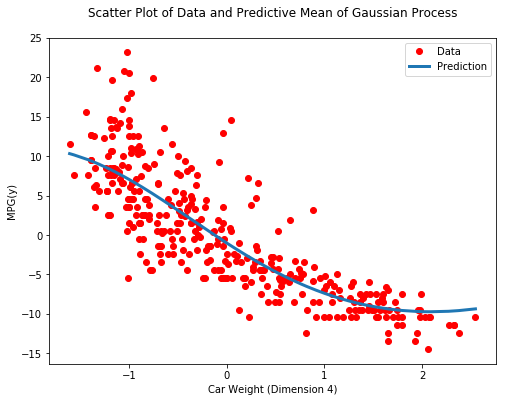

In [10]:
plt.figure(figsize = (8,6))
plt.plot(dim4[3], y_train, 'ro', label = 'Data')
plt.plot(*zip(*solid_estimate), linewidth = 3, label  = 'Prediction')
plt.title('Scatter Plot of Data and Predictive Mean of Gaussian Process\n')
plt.xlabel('Car Weight (Dimension 4)')
plt.ylabel('MPG(y)')
plt.legend(numpoints = 1);